# Mobile Color Family

In this notebook, I will attempt to use the product images to determine the color of each mobile device. 

## Imports

In [54]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pickle

from sklearn.model_selection import train_test_split
from keras.layers import Dense, GlobalAveragePooling2D
from keras.utils import np_utils

from keras.applications.vgg16 import VGG16
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16

%matplotlib inline
pd.options.mode.chained_assignment = None

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

## Loading the data sets

In [3]:
# mobile = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Capstone/mobile_data_info_train_competition.csv')
# tags = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Capstone/tags.csv')
mobile = pd.read_csv('mobile_data_info_train_competition.csv')
tags = pd.read_csv('tags.csv')

In [4]:
mobile_color = mobile[['itemid', 'image_path', 'Color Family']]
mobile_color.head()

,itemid,image_path,Color Family
0,2346660,mobile_image/a9c8f0fdd6587deed197634066cf7eee.jpg,12.0
1,2816338,mobile_image/3b9a11608551b11b9330268e0d055e01.jpg,12.0
2,2847602,mobile_image/1d719e936841a83c165da620f927de68.jpg,12.0
3,3116949,mobile_image/1d35a74d90df6cf4a02e6a5df9e9ff29.jpg,12.0
4,3794648,mobile_image/5556577b09539a9c0db0d00e0f171e2d.jpg,NaN


In [5]:
mobile_color.isnull().sum()

itemid              0
image_path          0
Color Family    75499
dtype: int64

In [6]:
tags_color = tags[['color', 'color_val']].dropna()
tags_color

,color,color_val
0,blue,4.0
1,gold,0.0
2,brown,14.0
3,navy blue,15.0
4,yellow,1.0
5,neutral,16.0
6,rose gold,17.0
7,light blue,3.0
8,dark grey,18.0
9,silver,19.0


## More EDA and Cleaning

In [7]:
mobile_color_filled = mobile_color.dropna()

In [8]:
mobile_color_filled['Color Family'].value_counts()

10.0    37350
0.0     17162
12.0     7883
13.0     6999
19.0     5596
4.0      3917
20.0     2359
6.0       848
2.0       671
25.0      594
7.0       384
14.0      373
1.0       327
11.0      196
18.0       79
16.0       63
17.0       23
22.0        4
3.0         1
24.0        1
23.0        1
Name: Color Family, dtype: int64

In [9]:
# putting the value counts into a dataframe
mobile_value_counts = {k:mobile_color_filled['Color Family'].value_counts()[k] for k in mobile_color_filled['Color Family'].value_counts().keys()}
mobile_value_counts = pd.DataFrame(mobile_value_counts.items()).rename(columns = {0:'color_val', 1:"frequency"})
mobile_value_counts.head()

,color_val,frequency
0,10.0,37350
1,0.0,17162
2,12.0,7883
3,13.0,6999
4,19.0,5596


In [10]:
# merging with the colors
mobile_value_counts = mobile_value_counts.merge(tags_color, on="color_val" )
mobile_value_counts.head()

,color_val,frequency,color
0,10.0,37350,black
1,0.0,17162,gold
2,12.0,7883,white
3,13.0,6999,red
4,19.0,5596,silver


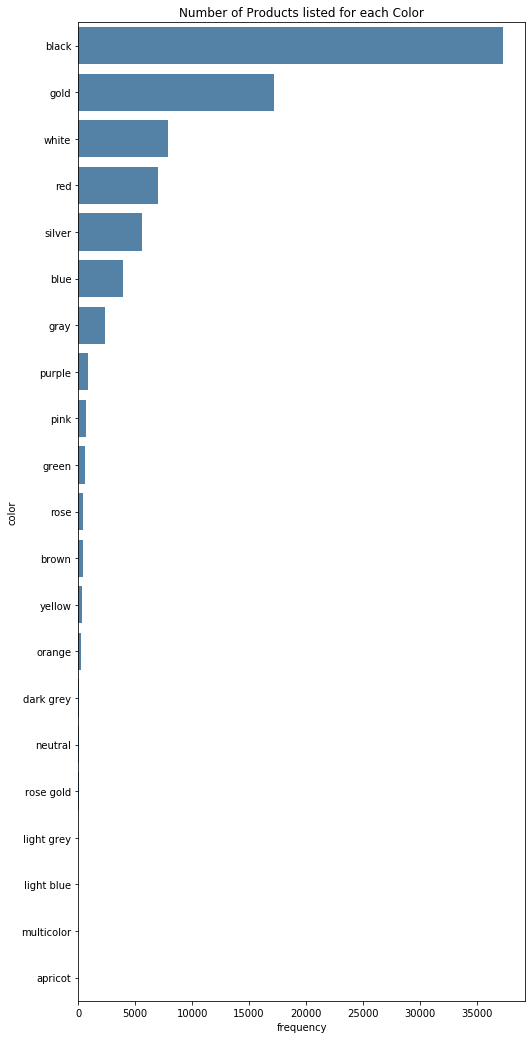

In [11]:
# visualizing the spread of the data
plt.figure(figsize=(8, 18))
ax_hist = plt.axes()
ax_hist.set_title(label ="Number of Products listed for each Color")
sns.barplot(x='frequency', y='color', data=mobile_value_counts, orient='h', color='steelblue')

From the histogram alone, we see that there are 7 main colours which the products belong to. I will be classifying the rest under 'others' for a total of 8 different classes for the model. 

## Feature Engineering

In [12]:
# summing up others
mobile_value_counts['frequency'][7:].sum()

3565

In [13]:
# extracting the top 7 colors
mobile_value_counts = mobile_value_counts.head(7)
mobile_value_counts

,color_val,frequency,color
0,10.0,37350,black
1,0.0,17162,gold
2,12.0,7883,white
3,13.0,6999,red
4,19.0,5596,silver
5,4.0,3917,blue
6,20.0,2359,gray


In [14]:
# extracting the color_val
mobile_top7 = {mobile_value_counts.at[i, "color_val"]:i for i in mobile_value_counts.index}
mobile_top7[100.0] = 7
mobile_top8 = mobile_top7
print(mobile_top8)

{10.0: 0, 0.0: 1, 12.0: 2, 13.0: 3, 19.0: 4, 4.0: 5, 20.0: 6, 100.0: 7}


In [15]:
# assiging the 8th class 'others'
mobile_value_counts.loc[8] = [100, 3565, 'others']

In [16]:
mobile_color_filled

,itemid,image_path,Color Family
0,2346660,mobile_image/a9c8f0fdd6587deed197634066cf7eee.jpg,12.0
1,2816338,mobile_image/3b9a11608551b11b9330268e0d055e01.jpg,12.0
2,2847602,mobile_image/1d719e936841a83c165da620f927de68.jpg,12.0
3,3116949,mobile_image/1d35a74d90df6cf4a02e6a5df9e9ff29.jpg,12.0
6,5769008,mobile_image/e088ca5ebb1ab5ba90a8cff8f9c4f791.jpg,10.0
...,...,...,...
160323,1510035980,mobile_image/4bd23a85f190ca5d416904a709274b1e.jpg,13.0
160325,1510771637,mobile_image/70e0d8ddd69692b0f134498efbddf4e1.jpg,10.0
160326,1515822742,mobile_image/d58393fe029ba62160d2a5d1fa6638a1.jpg,10.0
160327,1516747666,mobile_image/bfacb3c9af2f6a597008e57fb2d34609.jpg,10.0


In [17]:
mobile_color_filled.rename(columns={'Color Family':'color_val'}, inplace=True)
mobile_color_filled['new_color_val'] = mobile_color_filled['color_val'].apply(lambda x : x if x in mobile_top8.keys() else 100)
mobile_color_filled.head()

,itemid,image_path,color_val,new_color_val
0,2346660,mobile_image/a9c8f0fdd6587deed197634066cf7eee.jpg,12.0,12.0
1,2816338,mobile_image/3b9a11608551b11b9330268e0d055e01.jpg,12.0,12.0
2,2847602,mobile_image/1d719e936841a83c165da620f927de68.jpg,12.0,12.0
3,3116949,mobile_image/1d35a74d90df6cf4a02e6a5df9e9ff29.jpg,12.0,12.0
6,5769008,mobile_image/e088ca5ebb1ab5ba90a8cff8f9c4f791.jpg,10.0,10.0


In [18]:
# reassigning the color values
mobile_color_filled['new_color_val'] = mobile_color_filled['new_color_val'].map(mobile_top8)

In [19]:
# verifying the change
mobile_color_filled['new_color_val'].value_counts()

0    37350
1    17162
2     7883
3     6999
4     5596
5     3917
7     3565
6     2359
Name: new_color_val, dtype: int64

I will be using a sample of the images (5000) to train the model for color classification.

In [20]:
# checking the spread of the sample
mobile_color_filled.sample(5000, random_state=42)['new_color_val'].value_counts()

0    2168
1     980
2     474
3     401
4     354
5     273
7     213
6     137
Name: new_color_val, dtype: int64

In [21]:
mobile_color_filled_sample = mobile_color_filled.sample(5000, random_state=42)
mobile_color_filled_sample = mobile_color_filled_sample[['itemid', 'image_path', 'new_color_val']]
mobile_color_filled_sample

,itemid,image_path,new_color_val
81169,130210286,mobile_image/5d67fea085b0245017628ffaaaa69540.jpg,2
146137,1409643243,mobile_image/4c8a119145b1dff426e34d9dd96bf096.jpg,6
69161,28210135,mobile_image/88c16e22a817ff738114e66203f0ef21.jpg,6
40555,989045608,mobile_image/ad899f2641693e3524fab59252b37029.jpg,1
142503,1847080890,mobile_image/40727fe4d654c9156edaf85243b765b5.jpg,0
...,...,...,...
5432,924432271,mobile_image/0e688ab954089bce15b70a1bb00b55a7.jpg,0
108908,1047304939,mobile_image/2b17b2514c40d02824282867fd42a7c0.jpg,0
101232,1763024981,mobile_image/ae73bded77f44c6b8634be25751dfef5.jpg,3
145153,1350825404,mobile_image/3ea62dd409320874303484ed47b234ef.jpg,0


## Preprocessing

We will be doing train test split on our known data (mobile_color_filled) to train our model.

In [22]:
X = [load_img(i, target_size=(224, 224)) for i in mobile_color_filled_sample['image_path']]
X = [img_to_array(i) for i in X]
X = [i.reshape(( i.shape[0], i.shape[1], i.shape[2])) for i in X]
X = np.array([preprocess_input(i) for i in X])

y = np_utils.to_categorical(np.array(mobile_color_filled_sample['new_color_val']))

In [23]:
X.shape

(5000, 224, 224, 3)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42)

In [25]:
X_train.shape

(3750, 224, 224, 3)

In [26]:
X_train[0]

array([[[151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        ...,
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ]],

       [[151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        ...,
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ]],

       [[151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        ...,
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ]],

       ...,

       [[151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        ...,
        [151.061  , 138.22

In [27]:
X_test[0]

array([[[151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        ...,
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ]],

       [[151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        ...,
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ]],

       [[151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        ...,
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ]],

       ...,

       [[151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        ...,
        [151.061  , 138.22

## Modelling

### VGG16

I will be using the VGG16 model to do transfer learning for the classification problem. This is due to the high performance of the VGG16 model and the fact that it is easily accessible. 

In [28]:
# load model without classifier layers
model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

In [29]:
# freezing the training layers
for layer in model.layers:
    layer.trainable = False

In [30]:
# add new classifier layers
flat1 = GlobalAveragePooling2D()(model.output)
output = Dense(8, activation='softmax')(flat1)

# define new model
model = Model(inputs=model.inputs, outputs=output)

In [31]:
# verifying the layers
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [32]:
# compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

For the purpose of compiling the rest of the code, I used a sample size to 5000, batch_size of 256 and 5 epochs. I originally obtained a val_accuracy of about 0.5 with a sample size of 20000, batch_size of 256 and 10 epochs.  

In [33]:
# fitting the model to the train and test set
history = model.fit(X_train,
                    y_train, 
                    batch_size=256,
                    validation_data=(X_test, y_test),
                    epochs=5,
                    verbose=1)

Train on 3750 samples, validate on 1250 samples
Epoch 1/5
3750/3750 [==============================] - 302s 80ms/step - loss: 9.0069 - accuracy: 0.1195 - val_loss: 5.6166 - val_accuracy: 0.2872
Epoch 2/5
3750/3750 [==============================] - 303s 81ms/step - loss: 5.3596 - accuracy: 0.2997 - val_loss: 5.1741 - val_accuracy: 0.2336
Epoch 3/5
3750/3750 [==============================] - 304s 81ms/step - loss: 4.5671 - accuracy: 0.2773 - val_loss: 4.3393 - val_accuracy: 0.2904
Epoch 4/5
3750/3750 [==============================] - 305s 81ms/step - loss: 3.8769 - accuracy: 0.2875 - val_loss: 3.9136 - val_accuracy: 0.3024
Epoch 5/5
3750/3750 [==============================] - 307s 82ms/step - loss: 3.4315 - accuracy: 0.3304 - val_loss: 3.6191 - val_accuracy: 0.3056


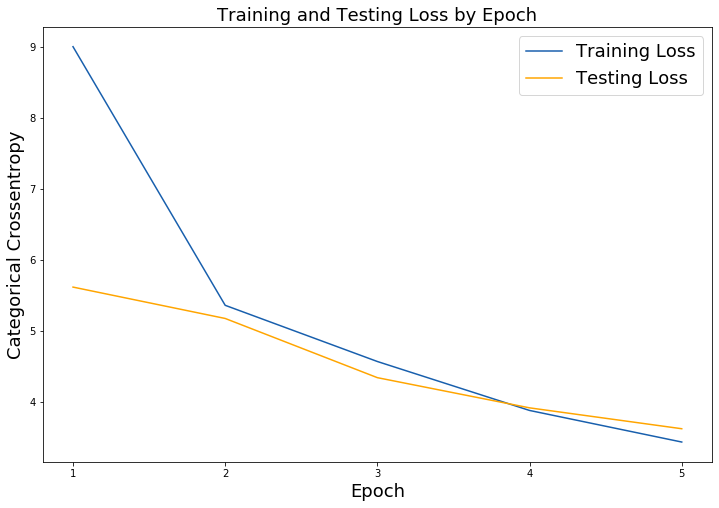

In [49]:
# check out our train loss and test loss over epochs
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# set figure size
plt.figure(figsize=(12, 8))

# generate line plot of training, testing loss over epochs
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# set title
plt.title('Training and Testing Loss by Epoch', fontsize = 18)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks([i for i in range(5)], [i for i in range(1, 6)])

plt.legend(fontsize = 18);

In [35]:
# evaluate model on test data
score = model.evaluate(X_test,
                       y_test,
                       verbose=1)

labels = model.metrics_names

1250/1250 [==============================] - 82s 65ms/step


In [36]:
# show model performance
print(f'{labels[0]}: {score[0]}')
print(f'{labels[1]}: {score[1]}')

loss: 3.6190620663642883
accuracy: 0.30559998750686646


In [37]:
predictions = model.predict_on_batch(X_test)

In [38]:
predictions[0]

array([1.9726828e-02, 6.4269151e-04, 2.6167402e-04, 3.8882022e-04,
       5.9929519e-04, 9.4857240e-01, 9.6978565e-06, 2.9798551e-02],
      dtype=float32)

In [39]:
predictions[50].argmax(axis=-1)

0

In [40]:
preds = []
for i in predictions:
    preds.append(i.argmax(axis = -1))


## Attempt to predict and autofill the missing data

In [50]:
# looking at the rows with the missing data
mobile_color_na = mobile_color.drop(mobile_color_filled.index)

In [51]:
mobile_color_na.head()

,itemid,image_path,Color Family
4,3794648,mobile_image/5556577b09539a9c0db0d00e0f171e2d.jpg,NaN
5,4980072,mobile_image/504bbab21ede157e6e3f1b93e6b6484c.jpg,NaN
7,9503620,mobile_image/a23f0381039e5595559be27db3271d2f.jpg,NaN
9,21715801,mobile_image/a5360d928a586de4b7dc5a8463f9fc26.jpg,NaN
14,46093583,mobile_image/a62e7e0e23294c030068e6ba47889333.jpg,NaN


In [61]:
mobile_value_counts['new_color_val'] = mobile_value_counts['color_val'].map(mobile_top8)
mobile_value_counts

,color_val,frequency,color,new_color_val
0,10.0,37350,black,0
1,0.0,17162,gold,1
2,12.0,7883,white,2
3,13.0,6999,red,3
4,19.0,5596,silver,4
5,4.0,3917,blue,5
6,20.0,2359,gray,6
8,100.0,3565,others,7


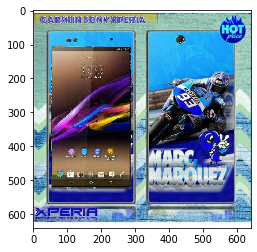

   new_color_val  color
0              0  black


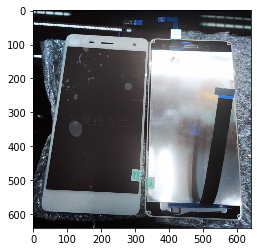

   new_color_val  color
2              2  white


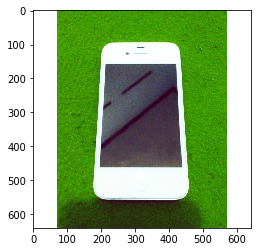

   new_color_val color
1              1  gold


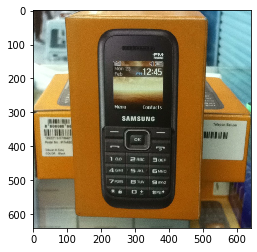

   new_color_val  color
0              0  black


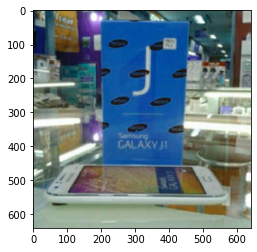

   new_color_val  color
0              0  black


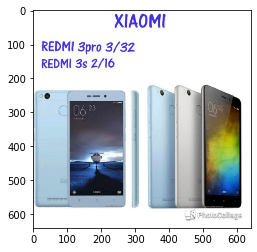

   new_color_val  color
0              0  black


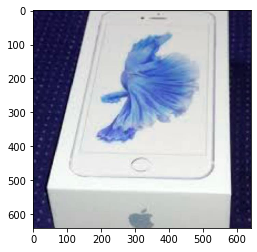

   new_color_val color
1              1  gold


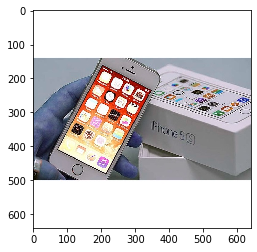

   new_color_val  color
0              0  black


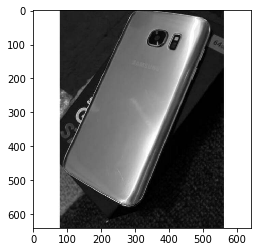

   new_color_val color
6              6  gray


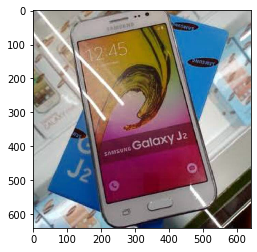

   new_color_val color
1              1  gold


In [71]:
# displaying the first 10 images
for img in mobile_color_na.head(10)['image_path']:
    
    image = load_img(img, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))    
    image = preprocess_input(image)    
    
    plt.imshow(cv2.imread(img))
    plt.show()
    pred = model.predict(image).argmax(axis=-1)
    print(mobile_value_counts[mobile_value_counts['new_color_val'] == pred[0]][['new_color_val', 'color']])


## Exporting the Model

In [55]:
pickle.dump(model, open('dlmodel.pkl','wb'))

## Conclusions and Findings

The machine does not predict the color of the mobile devices very well. It seems like there are many white phones which are wrongly predicted as either black or gold. 

The explanantion for this is largely due to the packaging of said phones. 

Apple's (rose)gold phone has a white front. The packaging of the phones are also white meaning that there is a good chance the machine has associated gold with white. There are also more than twice as many gold phones compared to white phones in the training data (17k vs 8k). As such, when presented with a white phone (regardless of brand) the model will predict a white phone as gold. 


In [77]:
model_check = VGG16()

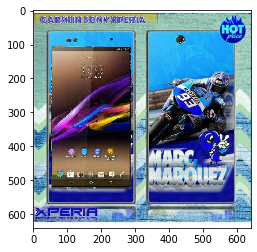

[[('n06359193', 'web_site', 0.53233814), ('n03782006', 'monitor', 0.13540521), ('n04149813', 'scoreboard', 0.059633173), ('n04152593', 'screen', 0.04014693), ('n06596364', 'comic_book', 0.034145802)]]


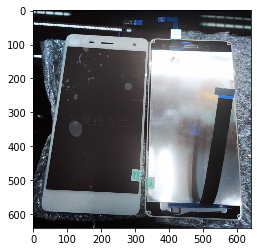

[[('n03642806', 'laptop', 0.05547568), ('n04264628', 'space_bar', 0.055459995), ('n04442312', 'toaster', 0.050854307), ('n03014705', 'chest', 0.045582443), ('n04505470', 'typewriter_keyboard', 0.036807783)]]


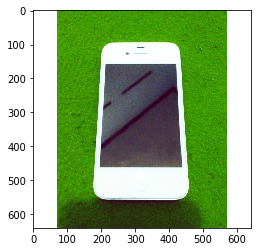

[[('n04372370', 'switch', 0.7209426), ('n04074963', 'remote_control', 0.09001196), ('n03584254', 'iPod', 0.07526557), ('n03777754', 'modem', 0.062178925), ('n03793489', 'mouse', 0.0061104256)]]


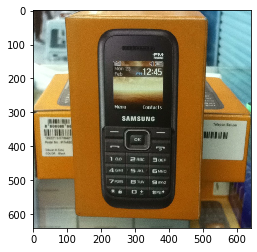

[[('n02992529', 'cellular_telephone', 0.405135), ('n03902125', 'pay-phone', 0.2213665), ('n03485407', 'hand-held_computer', 0.07637188), ('n02977058', 'cash_machine', 0.058634643), ('n03584254', 'iPod', 0.026757073)]]


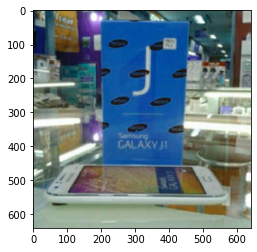

[[('n04443257', 'tobacco_shop', 0.23369874), ('n03461385', 'grocery_store', 0.122610584), ('n04462240', 'toyshop', 0.09138862), ('n02871525', 'bookshop', 0.07363204), ('n03661043', 'library', 0.06001153)]]


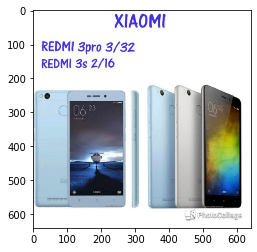

[[('n04372370', 'switch', 0.14749056), ('n04152593', 'screen', 0.10959063), ('n03782006', 'monitor', 0.10873914), ('n03857828', 'oscilloscope', 0.07051647), ('n03584254', 'iPod', 0.05852056)]]


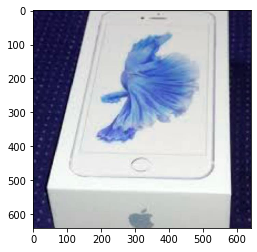

[[('n02978881', 'cassette', 0.12668513), ('n02840245', 'binder', 0.09149884), ('n03584254', 'iPod', 0.08511574), ('n04476259', 'tray', 0.07709238), ('n03908714', 'pencil_sharpener', 0.07567125)]]


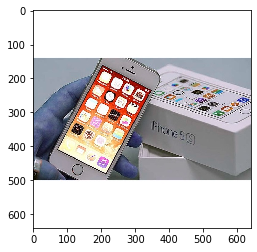

[[('n04074963', 'remote_control', 0.81028605), ('n03485407', 'hand-held_computer', 0.04437751), ('n02786058', 'Band_Aid', 0.030481575), ('n04116512', 'rubber_eraser', 0.020015448), ('n03924679', 'photocopier', 0.016083233)]]


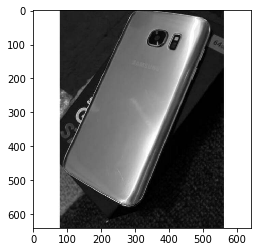

[[('n03666591', 'lighter', 0.54370934), ('n03777754', 'modem', 0.13414146), ('n04372370', 'switch', 0.112535104), ('n04074963', 'remote_control', 0.07825245), ('n02992529', 'cellular_telephone', 0.018844476)]]


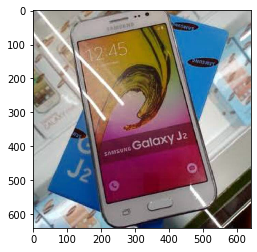

[[('n03777754', 'modem', 0.16020505), ('n03584254', 'iPod', 0.15673408), ('n02992529', 'cellular_telephone', 0.06955112), ('n04116512', 'rubber_eraser', 0.0516826), ('n03492542', 'hard_disc', 0.05041571)]]


In [81]:
for img in mobile_color_na.head(10)['image_path']:
    
    image = load_img(img, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))    
    image = preprocess_input(image)  
    plt.imshow(cv2.imread(img))
    plt.show()
    print(decode_predictions(model_check.predict(image)))

Using the base VGG16 model to check the same images shows interesting results. 

In all the 10 images, 'cellular_telephone' (Synset: cellular telephone, cellular phone, cellphone, cell, mobile phone) did not show up as the top result despite them being all mobile phone images. This suggests that the images uploaded could have been better without their packaging or other obstructions. 

As such for the auto-categorising of colors, it would be best to suggest to users to upload the actual image of their product. Similar to the mobile brand, some human resources should be placed to handle those devices classified under 'Others' to cover the less common colors in the database. 